In [1]:

import logging
import gin
gin.clear_config()

import os
import accelerate
import traceback
from internal.configs import Config
from internal import configs
from internal import models

from typing import Any, Dict

import numpy as np
import torch

from internal import camera_utils

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(), logging.FileHandler("nerf_server.log")],
)
logger = logging.getLogger(__name__)

nerf_model = None
config = None
accelerator = None
device = "cuda" if torch.cuda.is_available() else "cpu"


/app/bilarf/gridencoder/grid.py:27: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, inputs, embeddings, offsets, per_level_scale, base_resolution, calc_grad_inputs=False, gridtype=0, align_corners=False, interpolation=0):
/app/bilarf/gridencoder/grid.py:68: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad):
/app/bilarf/gridencoder/grid.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [2]:
def load_config(config_path, bindings=None):
    if bindings is None:
        bindings = []
    
    gin.parse_config_files_and_bindings(
        [config_path], bindings, skip_unknown=True)
    config = Config()

        
    return config

In [123]:
gin.clear_config()
config = load_config("configs/train.gin")
config.data_dir = "/app/data/captures/test_apr29_1"

In [4]:
from internal import checkpoints


def load_nerf_model(checkpoint_dir: str) -> bool:
    """Load a NeRF model from a checkpoint directory"""
    global nerf_model, config, accelerator

    try:
        logger.info(f"Loading NeRF model from checkpoint: {checkpoint_dir}")

        # Check if path exists
        if not os.path.exists(checkpoint_dir):
            logger.error(f"Checkpoint directory not found: {checkpoint_dir}")
            return False

        # Restore the checkpoint
        from accelerate import Accelerator
        accelerator = Accelerator()
        
        # Set dataset info based on expected config values
        dataset_info_for_model = {
            'size': 49,  # Just a placeholder, not used for rendering
        }
        
        # Create and prepare model
        nerf_model = models.Model(config=config, dataset_info=dataset_info_for_model)
        nerf_model.eval()
        nerf_model = accelerator.prepare(nerf_model)
        
        # Restore checkpoint
        step = checkpoints.restore_checkpoint(checkpoint_dir, accelerator, logger, strict=config.load_state_dict_strict)
        logger.info(f"Successfully loaded NeRF model from checkpoint at step {step}")

        return True
    except Exception as e:
        logger.error(f"Error loading NeRF model: {str(e)}")
        logger.error(traceback.format_exc())
        return False


In [ ]:
def pad_poses(p):
    """Pad [..., 3, 4] pose matrices with a homogeneous bottom row [0,0,0,1]."""
    bottom = np.broadcast_to([0, 0, 0, 1.], p[..., :1, :4].shape)
    return np.concatenate([p[..., :3, :4], bottom], axis=-2)

def create_rays_from_camera_params(params: Dict[str, Any]) -> Dict[str, torch.Tensor]:
    """Create rays from the provided camera parameters, similar to generate_ray_batch"""
    width = params["width"]
    height = params["height"]
    transform = np.array(params['transform'], dtype=np.float32)
    scaling_factor = params['scaling_factor']
    
    camtoworld_list = params["camtoworld"]                                                       
    camtoworld = np.array(camtoworld_list, dtype=np.float32)

    # Ensure it's 4x4
    if camtoworld.shape == (3, 4):
        camtoworld = pad_poses(camtoworld)
    elif camtoworld.shape == (4, 4):
        raise ValueError(f"camtoworld must be 3x4 or 4x4 matrix, got {camtoworld.shape}")
    
    # Switch from COLMAP (right, down, fwd) to NeRF (right, up, back) frame.
    # camtoworld = camtoworld @ np.diag([1, -1, -1, 1])

    camtoworld = transform @ camtoworld
    camtoworld[:3, 3] *= scaling_factor
    
    # Ensure it's 3x4
    camtoworld = camtoworld[:3, :]
    
    focal_x = params["focal_x"]
    focal_y = params["focal_y"]
    cx = params["cx"]
    cy = params["cy"]
    image_downsample_fac = params["image_downsample_fac"]
    # # Create inverse intrinsic matrix (pixel to camera)
    pixtocam = np.linalg.inv(camera_utils.intrinsic_matrix(focal_x, focal_y, cx, cy))
    pixtocam = np.array(pixtocam, dtype=np.float32)
    pixtocam = pixtocam @ np.diag([image_downsample_fac, image_downsample_fac, 1.])
    pixtocam = np.array(pixtocam, dtype=np.float32)    
    
    # Generate pixel coordinates - output shape is (height, width)
    pix_x_int, pix_y_int = camera_utils.pixel_coordinates(width, height)

    cam_idx = 0  # Since we're just using one camera
    
    # Prepare camera parameters
    cameras = (
        pixtocam, 
        camtoworld,
        None,  # distortion_params
        None   # pixtocam_ndc
    )
    
    # Prepare pixel parameters
    near = config.near if config else 0.2
    far = config.far if config else 1000.0
    
    broadcast_scalar = lambda x: np.broadcast_to(x, pix_x_int.shape)[..., None]
    
    ray_kwargs = {
        'lossmult': broadcast_scalar(1.),
        'near': broadcast_scalar(near),
        'far': broadcast_scalar(far),
        'cam_idx': broadcast_scalar(cam_idx),
    }
    
    pixels = {
        'pix_x_int': pix_x_int, 
        'pix_y_int': pix_y_int, 
        **ray_kwargs
    }
    
    # Use camera_utils to cast rays
    batch = camera_utils.cast_ray_batch(cameras, pixels, camera_utils.ProjectionType.PERSPECTIVE)
    
    # Add cam_dirs (needed by model) - FIX: broadcast to the right shape
    cam_dirs = -camtoworld[:3, 2]  # Extract camera forward direction
    batch['cam_dirs'] = np.broadcast_to(cam_dirs, pix_x_int.shape + (3,))
    
    # Add normalized pixel coordinates
    pix_x_float = (pix_x_int.astype(np.float32) + 0.5) / width
    pix_y_float = (pix_y_int.astype(np.float32) + 0.5) / height
    batch['pix_xy'] = np.stack([pix_x_float, pix_y_float], axis=-1)
    print(batch['pix_xy'])
    
    # Convert to torch tensors
    batch = {k: torch.from_numpy(v.copy()).float() if v is not None else None for k, v in batch.items()}

    for k, v in batch.items():
        if v is not None:
            logger.debug(f"Ray batch tensor '{k}' has shape {v.shape}")
    
    return batch

In [6]:
from torch.utils._pytree import tree_map

def render_image_from_rays(ray_batch, height, width, config, nerf_model, accelerator):
    """A simpler wrapper around models.render_image that adds extra debugging"""
    # Move batch to device 
    ray_batch = tree_map(lambda x: x.to(accelerator.device) if x is not None else None, ray_batch)
    
    # Call render_image with the flattened batch
    with torch.no_grad():
        rendering = models.render_image(
            nerf_model, 
            accelerator, 
            ray_batch,
            rand=False,
            train_frac=1.0,
            config=config,
            verbose=True
        )
    
    return rendering

In [117]:
load_nerf_model("exp/test_apr29_1/checkpoints")

2025-05-24 16:58:35,587 - __main__ - INFO - Loading NeRF model from checkpoint: exp/test_apr29_1/checkpoints
2025-05-24 16:58:36,276 - __main__ - INFO - Resuming from checkpoint exp/test_apr29_1/checkpoints/025000
2025-05-24 16:58:36,277 - accelerate.accelerator - INFO - Loading states from exp/test_apr29_1/checkpoints/025000
2025-05-24 16:58:36,528 - accelerate.checkpointing - INFO - All model weights loaded successfully
2025-05-24 16:58:36,529 - accelerate.checkpointing - INFO - All optimizer states loaded successfully
2025-05-24 16:58:36,530 - accelerate.checkpointing - INFO - All scheduler states loaded successfully
2025-05-24 16:58:36,532 - accelerate.checkpointing - INFO - All dataloader sampler states loaded successfully
2025-05-24 16:58:36,537 - accelerate.checkpointing - INFO - All random states loaded successfully
2025-05-24 16:58:36,539 - accelerate.accelerator - INFO - Loading in 0 custom states
2025-05-24 16:58:36,540 - __main__ - INFO - Successfully loaded NeRF model from

True

In [150]:
camtoworld = [[ 0.92515859,  0.22006658, -0.30927703,  1.41879892],
 [ 0.14209328, -0.95632995, -0.25542617, -2.34771575],
 [-0.35198165,  0.19236353, -0.91602685, -1.21624539]]        

transform = [
    [
      0.33949030538545366,
      -0.9401101949977007,
      -0.03064561650018798,
      0.40502799888040486
    ],
    [
      -0.7538602695514978,
      -0.29142801394611134,
      0.588867053484204,
      0.15589131990937016
    ],
    [
      -0.5625309116315604,
      -0.17681214310338098,
      -0.8076487104615194,
      0.45412532856495935
    ],
    [
      0.0,
      0.0,
      0.0,
      1.0
    ]
  ]

scaling_factor =  0.12106293726660113
fx, fy, cx, cy = 1773.294491, 1773.544729, 1502.500000, 2032.500000
image_downsample_fac = 4

request_data = {'camera': {'camtoworld': camtoworld, 'transform': transform, 'scaling_factor': scaling_factor,  'focal': 1773.2944910750875, 'width': 751, 'height': 1016, 'focal_x': fx, 'focal_y': fy, 'cx': cx, 'cy': cy, 'image_downsample_fac': image_downsample_fac}}

In [152]:
data = request_data
logger.debug(f"Request data: {data}")

camera_params = data.get("camera")

# Extract width and height for later use
width = camera_params["width"]
height = camera_params["height"]

# Create rays from camera parameters
logger.info("Creating rays from camera parameters")
ray_batch = create_rays_from_camera_params(camera_params)

# Render the view
logger.info("Rendering view")
print(config)
rendering = render_image_from_rays(ray_batch, height, width, config, nerf_model, accelerator)

# Convert to numpy
rendering = tree_map(lambda x: x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x, rendering)

# Process results
result = {}
if 'rgb' in rendering:
    result["image"] = rendering['rgb']

if 'distance_mean' in rendering:
    result["depth_mean"] = rendering['distance_mean']

if 'distance_median' in rendering:
    result["depth_median"] = rendering['distance_median']

if 'normals' in rendering:
    result["normals"] = rendering['normals']

if 'acc' in rendering:
    result["acc"] = rendering['acc']
    
logger.info("Rendering completed successfully")



2025-05-24 20:07:07,485 - __main__ - DEBUG - Request data: {'camera': {'camtoworld': [[0.92515859, 0.22006658, -0.30927703, 1.41879892], [0.14209328, -0.95632995, -0.25542617, -2.34771575], [-0.35198165, 0.19236353, -0.91602685, -1.21624539]], 'transform': [[0.33949030538545366, -0.9401101949977007, -0.03064561650018798, 0.40502799888040486], [-0.7538602695514978, -0.29142801394611134, 0.588867053484204, 0.15589131990937016], [-0.5625309116315604, -0.17681214310338098, -0.8076487104615194, 0.45412532856495935], [0.0, 0.0, 0.0, 1.0]], 'scaling_factor': 0.12106293726660113, 'focal': 1773.2944910750875, 'width': 751, 'height': 1016, 'focal_x': 1773.294491, 'focal_y': 1773.544729, 'cx': 1502.5, 'cy': 2032.5, 'image_downsample_fac': 4}}
2025-05-24 20:07:07,488 - __main__ - INFO - Creating rays from camera parameters
2025-05-24 20:07:07,864 - __main__ - DEBUG - Ray batch tensor 'origins' has shape torch.Size([1016, 751, 3])
2025-05-24 20:07:07,866 - __main__ - DEBUG - Ray batch tensor 'direc

[[[6.6577893e-04 4.9212598e-04]
  [1.9973370e-03 4.9212598e-04]
  [3.3288947e-03 4.9212598e-04]
  ...
  [9.9667108e-01 4.9212598e-04]
  [9.9800265e-01 4.9212598e-04]
  [9.9933422e-01 4.9212598e-04]]

 [[6.6577893e-04 1.4763779e-03]
  [1.9973370e-03 1.4763779e-03]
  [3.3288947e-03 1.4763779e-03]
  ...
  [9.9667108e-01 1.4763779e-03]
  [9.9800265e-01 1.4763779e-03]
  [9.9933422e-01 1.4763779e-03]]

 [[6.6577893e-04 2.4606299e-03]
  [1.9973370e-03 2.4606299e-03]
  [3.3288947e-03 2.4606299e-03]
  ...
  [9.9667108e-01 2.4606299e-03]
  [9.9800265e-01 2.4606299e-03]
  [9.9933422e-01 2.4606299e-03]]

 ...

 [[6.6577893e-04 9.9753934e-01]
  [1.9973370e-03 9.9753934e-01]
  [3.3288947e-03 9.9753934e-01]
  ...
  [9.9667108e-01 9.9753934e-01]
  [9.9800265e-01 9.9753934e-01]
  [9.9933422e-01 9.9753934e-01]]

 [[6.6577893e-04 9.9852359e-01]
  [1.9973370e-03 9.9852359e-01]
  [3.3288947e-03 9.9852359e-01]
  ...
  [9.9667108e-01 9.9852359e-01]
  [9.9800265e-01 9.9852359e-01]
  [9.9933422e-01 9.9852359e-

2025-05-24 20:07:12,825 - __main__ - INFO - Rendering completed successfully                                                                                                             


[[[0.620684   0.63794714 0.6284904 ]
  [0.61933714 0.6361992  0.6257045 ]
  [0.6179791  0.63485926 0.62441224]
  ...
  [0.3985856  0.41514874 0.46181634]
  [0.39610708 0.41222623 0.45671242]
  [0.39657757 0.40709463 0.4536636 ]]

 [[0.6173633  0.63455784 0.62563694]
  [0.62185246 0.6390013  0.62882715]
  [0.6188915  0.63585234 0.6256086 ]
  ...
  [0.397705   0.41308522 0.46252534]
  [0.39424327 0.40917566 0.45468637]
  [0.39537892 0.40248162 0.44966257]]

 [[0.60986346 0.62684244 0.6178971 ]
  [0.6122703  0.62933356 0.6199313 ]
  [0.6152444  0.6324168  0.6218547 ]
  ...
  [0.39597368 0.41092363 0.457851  ]
  [0.39049146 0.40093172 0.44738898]
  [0.38076678 0.39051577 0.43608165]]

 ...

 [[0.13417557 0.1366145  0.12032974]
  [0.13006966 0.13424687 0.1195185 ]
  [0.13676268 0.14116497 0.12183786]
  ...
  [0.03659979 0.05009107 0.01952688]
  [0.05150596 0.06352923 0.02767282]
  [0.05607422 0.06343631 0.02889039]]

 [[0.14522117 0.14646909 0.13078065]
  [0.12787215 0.13054293 0.11286773]


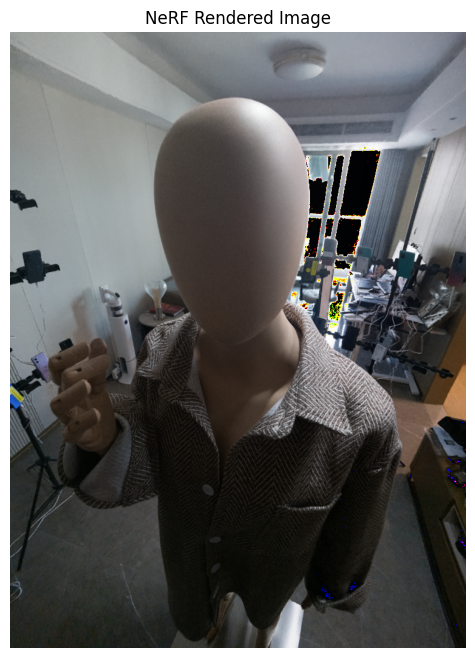

In [153]:
from PIL import Image
from IPython.display import Image as IPyImage
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os

rgb = result["image"]
print(rgb)
    
# Convert to uint8 for saving
rgb_uint8 = (rgb * 255).astype(np.uint8)

# Create directory if it doesn't exist
os.makedirs("exp/dump", exist_ok=True)

# Save the image
rgb_path = os.path.join("exp/dump", "nerf_rgb.png")
Image.fromarray(rgb_uint8).save(rgb_path)


plt.figure(figsize=(10, 8))
plt.imshow(rgb_uint8)
plt.axis('off')
plt.title('NeRF Rendered Image')
plt.show()